In [14]:
 import csv
import datetime
from statistics import mean
from sklearn.model_selection import cross_val_score, KFold
from IPython.display import display
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Sequential, utils
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay,classification_report, accuracy_score, plot_confusion_matrix, accuracy_score
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Conv1D, MaxPooling1D, MaxPooling2D,MaxPooling3D,BatchNormalization, MaxPool2D
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import logging, os
import matplotlib.pyplot as plt
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import random
import pandas as pd

In [3]:
class Read:
    def __init__(self,filename):
        self.reader = csv.reader(open(filename), delimiter = ",")
        self.data = list(self.reader)
        self.data.pop(0)

In [4]:
class Game:
    id = 0
    def __init__(self,data):
        Game.id += 1
        self.id = Game.id
        self.data = data
        index = 0
        for i in range(len(self.data)):
            try:
                self.data[i] = int(self.data[i])
            except:
                pass
        self.game_data = self.data[1:22]
        self.pregame_data = self.data[1:4]
        self.date = self.data[1]
        self.time = self.data[2]
        self.h_team = self.data[3]
        self.a_team = self.data[4]
        self.h_score = self.data[5]  
        self.a_score = self.data[6]
        if self.data[7] == "H":
            self.result = 0
        elif self.data[7] == "D":
            self.result = 1
        elif self.data[7] == "A":
            self.result = 2
        else:
            print("error")
        self.h_half_goals = self.data[8] #goals at half time
        self.a_half_goals = self.data[9] 
        self.half_result = self.data[10] 
        self.referee = self.data[11]
        self.h_shots = self.data[12]
        self.a_shots = self.data[13]
        self.h_shots_ontarg = self.data[14]
        self.a_shots_ontarg = self.data[15]
        self.h_fouls = self.data[16]
        self.a_fouls = self.data[17]
        self.h_corners = self.data[18]
        self.a_corners = self.data[19]
        self.h_yellow = self.data[20]
        self.a_yellow = self.data[21]
        self.h_red = self.data[22]
        self.a_red = self.data[23]

In [5]:
class Team:
    id = 0
    def __init__(self, name):
        Team.id += 1
        self.id = Team.id 
        self.name = name
        self.games = []
    
    def add_game(self,game):
        self.games.append(game)

    def get_id(self):
        return self.id
        
    def get_name(self):
        return self.name
    
    def get_games_before(self,game):
        games_before = []
        count = 0
        for i in self.games:
            if i == game:
                return self.games[:count]
            count+=1
        return []
    
    def get_stats(self,game_list):
        #stats avg([goals_scored,conceded,halfgoals,halfconceded,shots,
        #shotsgiven,shotson,shotsongiven,foulsgiven,fouls,corners,
        #cornersgiven,yellowgiven,yellow,redgiven,red])
        stats = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        game_count = 0
        for i in game_list:
            if (i.h_team == self.name):
                game_count += 1
                stats[0] += i.h_score
                stats[1] += i.a_score
                stats[2] += i.h_half_goals
                stats[3] += i.a_half_goals
                stats[4] += i.h_shots
                stats[5] += i.a_shots
                stats[6] += i.h_shots_ontarg
                stats[7] += i.a_shots_ontarg
                stats[8] += i.h_fouls
                stats[9] += i.a_fouls
                stats[10] += i.h_corners
                stats[11] += i.a_corners
                stats[12] += i.h_yellow
                stats[13] += i.a_yellow
                stats[14] += i.h_red
                stats[15] += i.a_red
                
            if (i.a_team == self.name):
                game_count += 1
                stats[0] += i.a_score
                stats[1] += i.h_score
                stats[2] += i.a_half_goals
                stats[3] += i.h_half_goals
                stats[4] += i.a_shots
                stats[5] += i.h_shots
                stats[6] += i.a_shots_ontarg
                stats[7] += i.h_shots_ontarg
                stats[8] += i.a_fouls
                stats[9] += i.h_fouls
                stats[10] += i.a_corners
                stats[11] += i.h_corners
                stats[12] += i.a_yellow
                stats[13] += i.h_yellow
                stats[14] += i.a_red
                stats[15] += i.h_red
        count = 0
        for j in range(len(stats)):
            count += 1
            if game_count !=0:
                stats[j] = round(stats[j]/game_count,2)
            else:
                stats = False
        return stats
  
    def get_stats_before(self,game):
        game_list = self.get_games_before(game)
        game_list
        stats = self.get_stats(game_list)
        return stats

In [6]:
read = Read("Data/19_20_data.csv")

games = list()
teams = list()
data = []
index = 0
labels = []

for result in read.data:
    games.append(Game(result))
    found = False
    for i in teams:
        if i.get_name() == result[3]:
            found = True
            break
    if (found == False):
        teams.append(Team(result[3]))
    found = False
    
for team in teams:
    for game in games:
        if game.h_team == team.name or game.a_team == team.name:
            team.add_game(game)

for game in games:
    data.append([[],[]])
    res = np.array(game.result)
    labels.append(res)
    for team in teams:
        if game.h_team == team.name:
            if team.get_stats_before(game):
                for i in team.get_stats_before(game):
                    data[index][0].append(i)
                data[index][0].append(team.id)
        elif game.a_team == team.name:
            if team.get_stats_before(game):
                for i in team.get_stats_before(game):
                    data[index][1].append(i)
                data[index][1].append(team.id)
    index+=1
    

data = data[10:]
labels = labels[10:]


np_labels = np.array(labels)
np_data = np.array(data)

home: 
168
Rate:
0.4540540540540541
draw: 
89
Rate:
0.24054054054054055
away: 
113
Rate:
0.3054054054054054


In [7]:
def build_model(data,labels):
    model = Sequential()

    model.add(Conv1D(32, (2), activation='relu', input_shape=train_data[0].shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv1D(64, (1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics = "accuracy")
    
    model_history = model.fit(data, labels, epochs=100, verbose = 0)
    
    return(model)
    

In [35]:
def evaluate_model(model,data,labels):
    model.evaluate(data,labels)
    model_pred = model.predict_classes(data)
    model_matrix = confusion_matrix(labels, model_pred)
    model_show = ConfusionMatrixDisplay(confusion_matrix = model_matrix)
    model_show.title = "Neural Network Matrix"
    model_show = model_show.plot()
    m = tf.keras.metrics.Accuracy()
    m.update_state(labels, model_pred)
    return(m.result().numpy())

In [36]:
def random_guess(test_labels):
    rand_labels = []
    for i in test_labels:
        rand = random.randint(0,2)
        rand_labels.append(rand)
    rand_labels = np.array(rand_labels)
    rand_matrix = confusion_matrix(test_labels, rand_labels)
    rand_show = ConfusionMatrixDisplay(confusion_matrix = rand_matrix)
    rand_show.title = "Random Guess Matrix"
    rand_show = rand_show.plot()
    g = tf.keras.metrics.Accuracy()
    g.update_state(test_labels, rand_labels)
    return(g.result().numpy())
    


fold 1:
3/3 [==============================] - 1s 7ms/step - loss: 0.9658 - accuracy: 0.5405


C:\Users\Sam\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


fold 2:
3/3 [==============================] - 1s 7ms/step - loss: 1.0403 - accuracy: 0.4459
fold 3:
3/3 [==============================] - 1s 6ms/step - loss: 1.2295 - accuracy: 0.5135
fold 4:
3/3 [==============================] - 1s 6ms/step - loss: 1.2015 - accuracy: 0.5676
fold 5:
3/3 [==============================] - 1s 7ms/step - loss: 0.9757 - accuracy: 0.5541
random accuracies: [0.4189189, 0.36486486, 0.21621622, 0.2972973, 0.36486486]
random average: 0.33243242
nn accuracies: [0.5405405, 0.44594595, 0.5135135, 0.5675676, 0.5540541]
nn average: 0.5243243


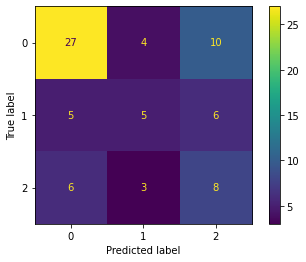

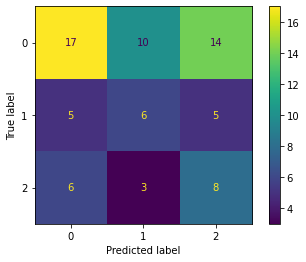

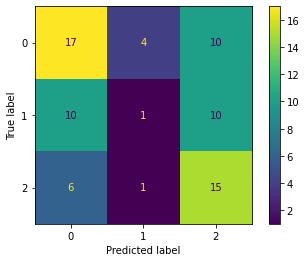

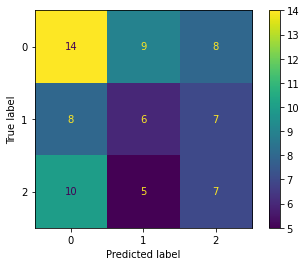

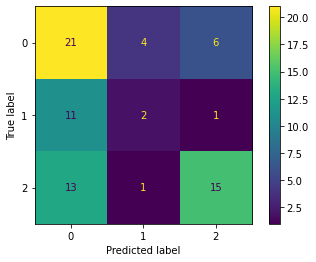

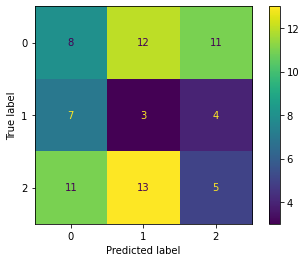

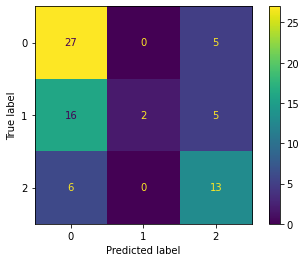

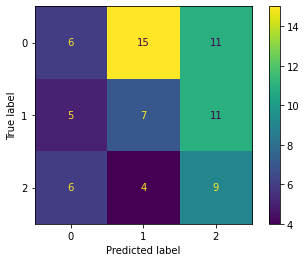

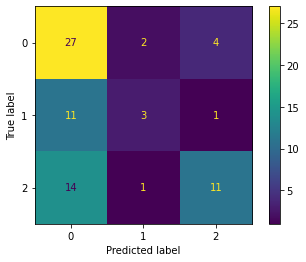

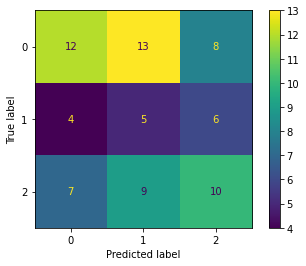

In [40]:
kf = KFold(5,shuffle=True)
fold = 0
nn_accuracies = []
rand_accuracies = []
for train_index, test_index in kf.split(np_data):
    fold+=1
    print("fold " + str(fold)+ ":")
    train_data, test_data = np_data[train_index], np_data[test_index]
    train_labels, test_labels = np_labels[train_index], np_labels[test_index]
    model = build_model(train_data,train_labels)
    nn_accuracies.append(evaluate_model(model,test_data,test_labels))
    rand_accuracies.append(random_guess(test_labels))
    
rand_avg = mean(rand_accuracies)
nn_avg = mean(nn_accuracies)
print("random accuracies: "+ str(rand_accuracies))
print("random average: "+ str(rand_avg))
print("nn accuracies: "+ str(nn_accuracies))
print("nn average: "+ str(nn_avg))

Text(0, 0.5, 'accuracy')

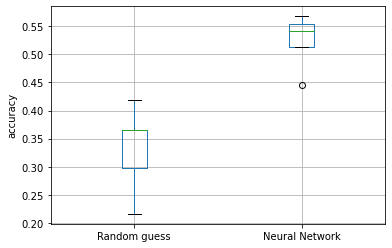

In [41]:
data = []
for i in range(len(rand_accuracies)):
    data.append((rand_accuracies[i],nn_accuracies[i]))
data = np.array(data)
df = pd.DataFrame(data,
                  columns=['Random guess','Neural Network'])

boxplot = df.boxplot(column=['Random guess','Neural Network'])
boxplot.set_ylabel("accuracy")

(0.4540540540540541, 0.24054054054054055, 0.3054054054054054)


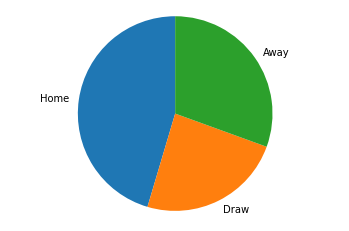

In [42]:
countH = 0
countD = 0
countA = 0
total = 0
for i in range(len(np_labels)):
    if np_labels[i] == 0:
        countH+=1
    elif np_labels[i] == 1:
        countD+=1
    elif np_labels[i] == 2:
        countA+=1
    total += 1
Hrate = countH/total
Drate = countD/total
Arate = countA/total
print(str((Hrate, Drate, Arate)))
labels = 'Home', 'Draw', 'Away'
sizes = [Hrate, Drate, Arate]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, startangle=90)
ax1.axis('equal') 

plt.show()